# COMP4030 - Data Science and Machine Learning - Coursework 2

In [1]:
from utils.gestures import *
from utils.operations import *
from utils.files import * 

import numpy as np
import pandas as pd

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [2]:
process_all_zips()

No unprocessed files found for circle
No unprocessed files found for come
No unprocessed files found for go
No unprocessed files found for wave


Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

df = get_data_from_files(scaler, 10) # 10 is the rows to trim from the beginning and end of the data
df

,time,accel_x,accel_y,accel_z,accel_abs,file_number,gesture
0,0.000000,0.559598,0.513468,0.226458,0.092301,0,circle
1,0.000728,0.568016,0.522626,0.197835,0.093494,0,circle
2,0.001457,0.517814,0.566211,0.222524,0.009878,0,circle
3,0.002185,0.484999,0.581607,0.242733,0.035518,0,circle
4,0.002913,0.510461,0.583776,0.212801,0.023593,0,circle
...,...,...,...,...,...,...,...
50967,0.997606,0.520334,0.913148,0.593166,0.001208,9,wave
50968,0.998205,0.519230,0.912340,0.590457,0.002987,9,wave
50969,0.998803,0.518487,0.908197,0.587279,0.005490,9,wave
50970,0.999402,0.518832,0.907147,0.585266,0.006249,9,wave


Next we visualise our raw data for exploratory analysis

In [4]:
SHOW_RAW_DATA = False

In [5]:
import math
import matplotlib.pyplot as plt

if SHOW_RAW_DATA:
      for gesture in get_gestures():
            
            group = df[df['gesture'] == gesture].groupby('file_number')
            
            if len(group) == 0:
                  continue

            cols = 2
            rows = math.ceil(len(group) / cols)
            plt.figure(figsize=(cols * 15, rows * 3))

            for index, df_group in enumerate(group):
                  plt.subplot(rows, cols, index + 1)
                  for col in get_columns()[1:]:
                        plt.plot(df_group[1].index, df_group[1][col], label=col)
                        plt.xticks(range(df_group[1].index[0], df_group[1].index[-1], 50))
                        plt.legend()
            plt.suptitle(gesture)
            plt.show()

We then try to segment this data, using the dips in acceleration that we had purposefully included in our data captures.

Firstly we visualise just one example to inspect the rolling standard deviation and attempt to find the optimal parameters for slicing our data.

In [6]:
rolling_window = 10
group_threshold = 10
deviation_threshold = 1.7

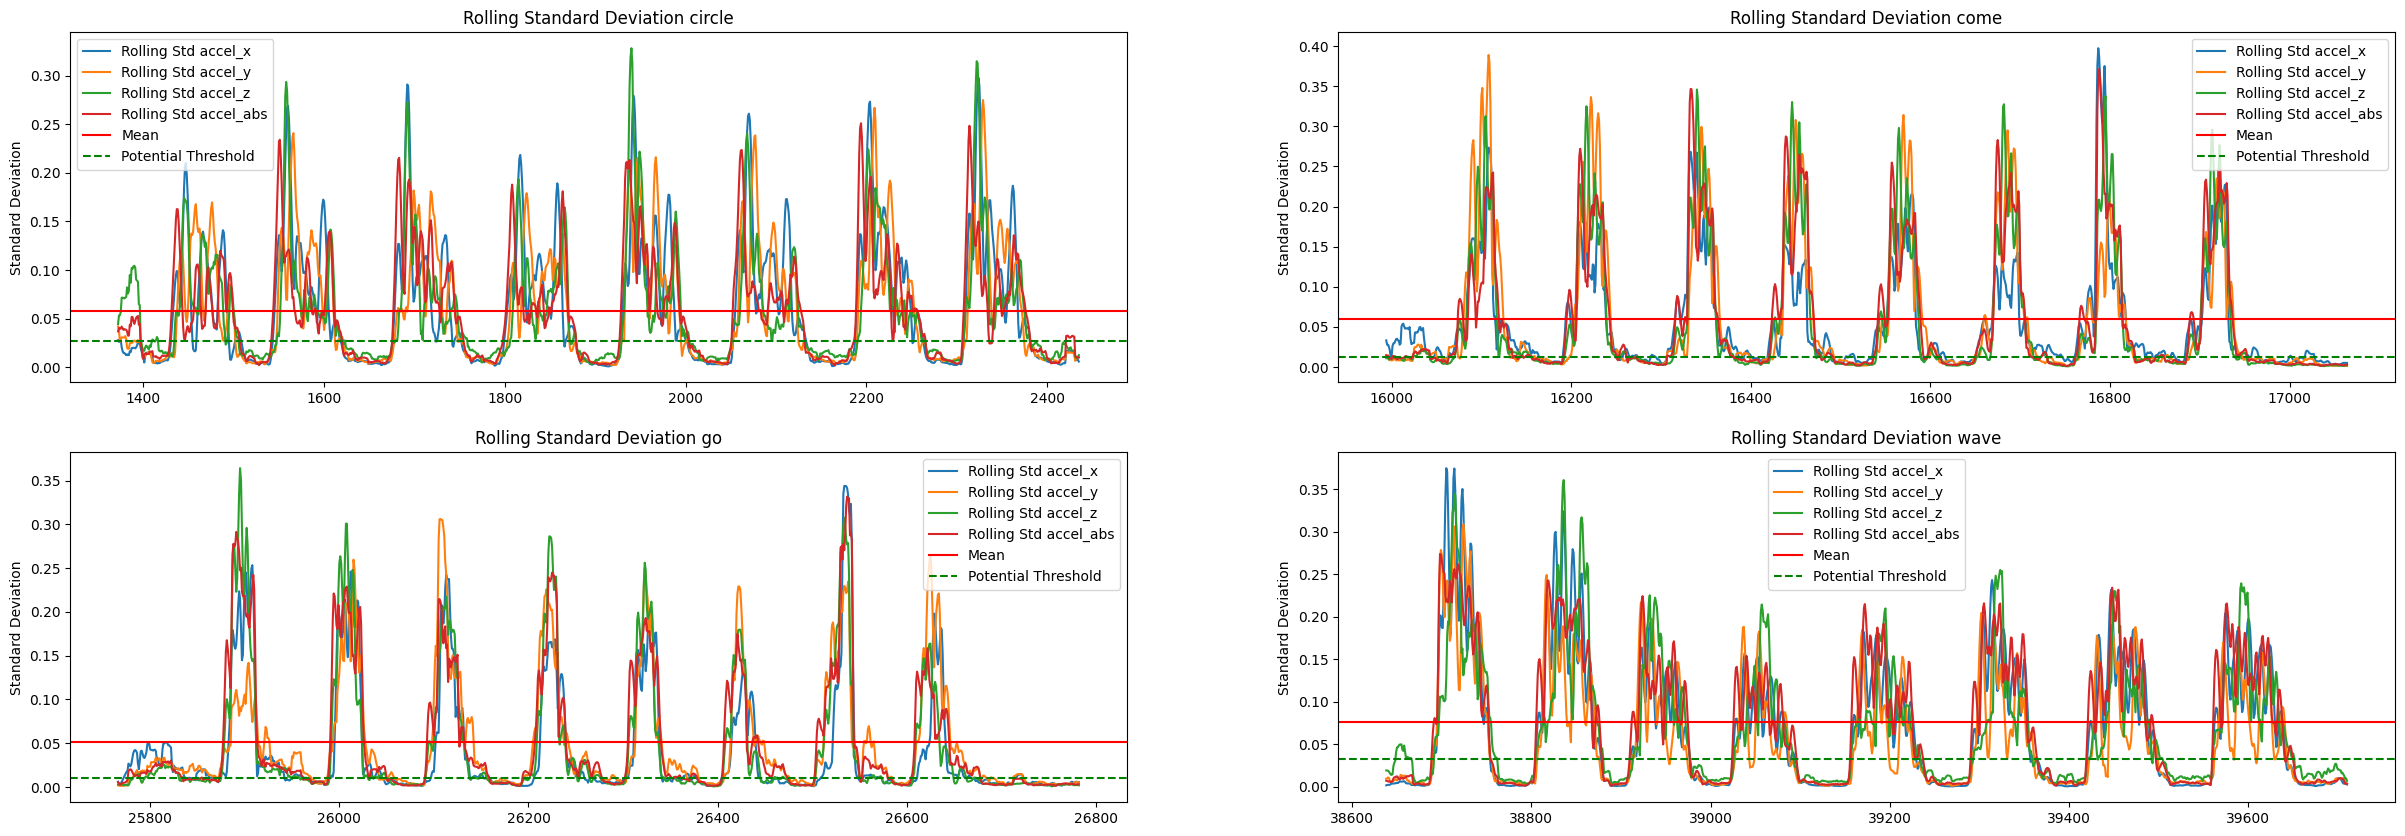

In [7]:
plt.figure(figsize=(30, 10))

for i, gesture in enumerate(get_gestures()):

      group = df[(df['gesture'] == gesture) & (df['file_number'] == 1)]
      if len(group) == 0:
            continue

      rolling_std = group['accel_abs'].rolling(window=rolling_window).std()
      threshold = rolling_std.mean() - rolling_std.std() / deviation_threshold

      plt.subplot(2, 2, i + 1)

      for col in get_columns()[1:]:
            plt.plot(group[col].rolling(window=rolling_window).std(), label=f'Rolling Std {col}')

      plt.axhline(y=rolling_std.mean(), color='r', linestyle='-', label='Mean')
      plt.axhline(y=threshold, color='g', linestyle='--', label='Potential Threshold')    
      plt.title(f'Rolling Standard Deviation {gesture}')
      plt.ylabel('Standard Deviation')
      plt.legend()

plt.show()

Then we visualise our slices for all of the data.

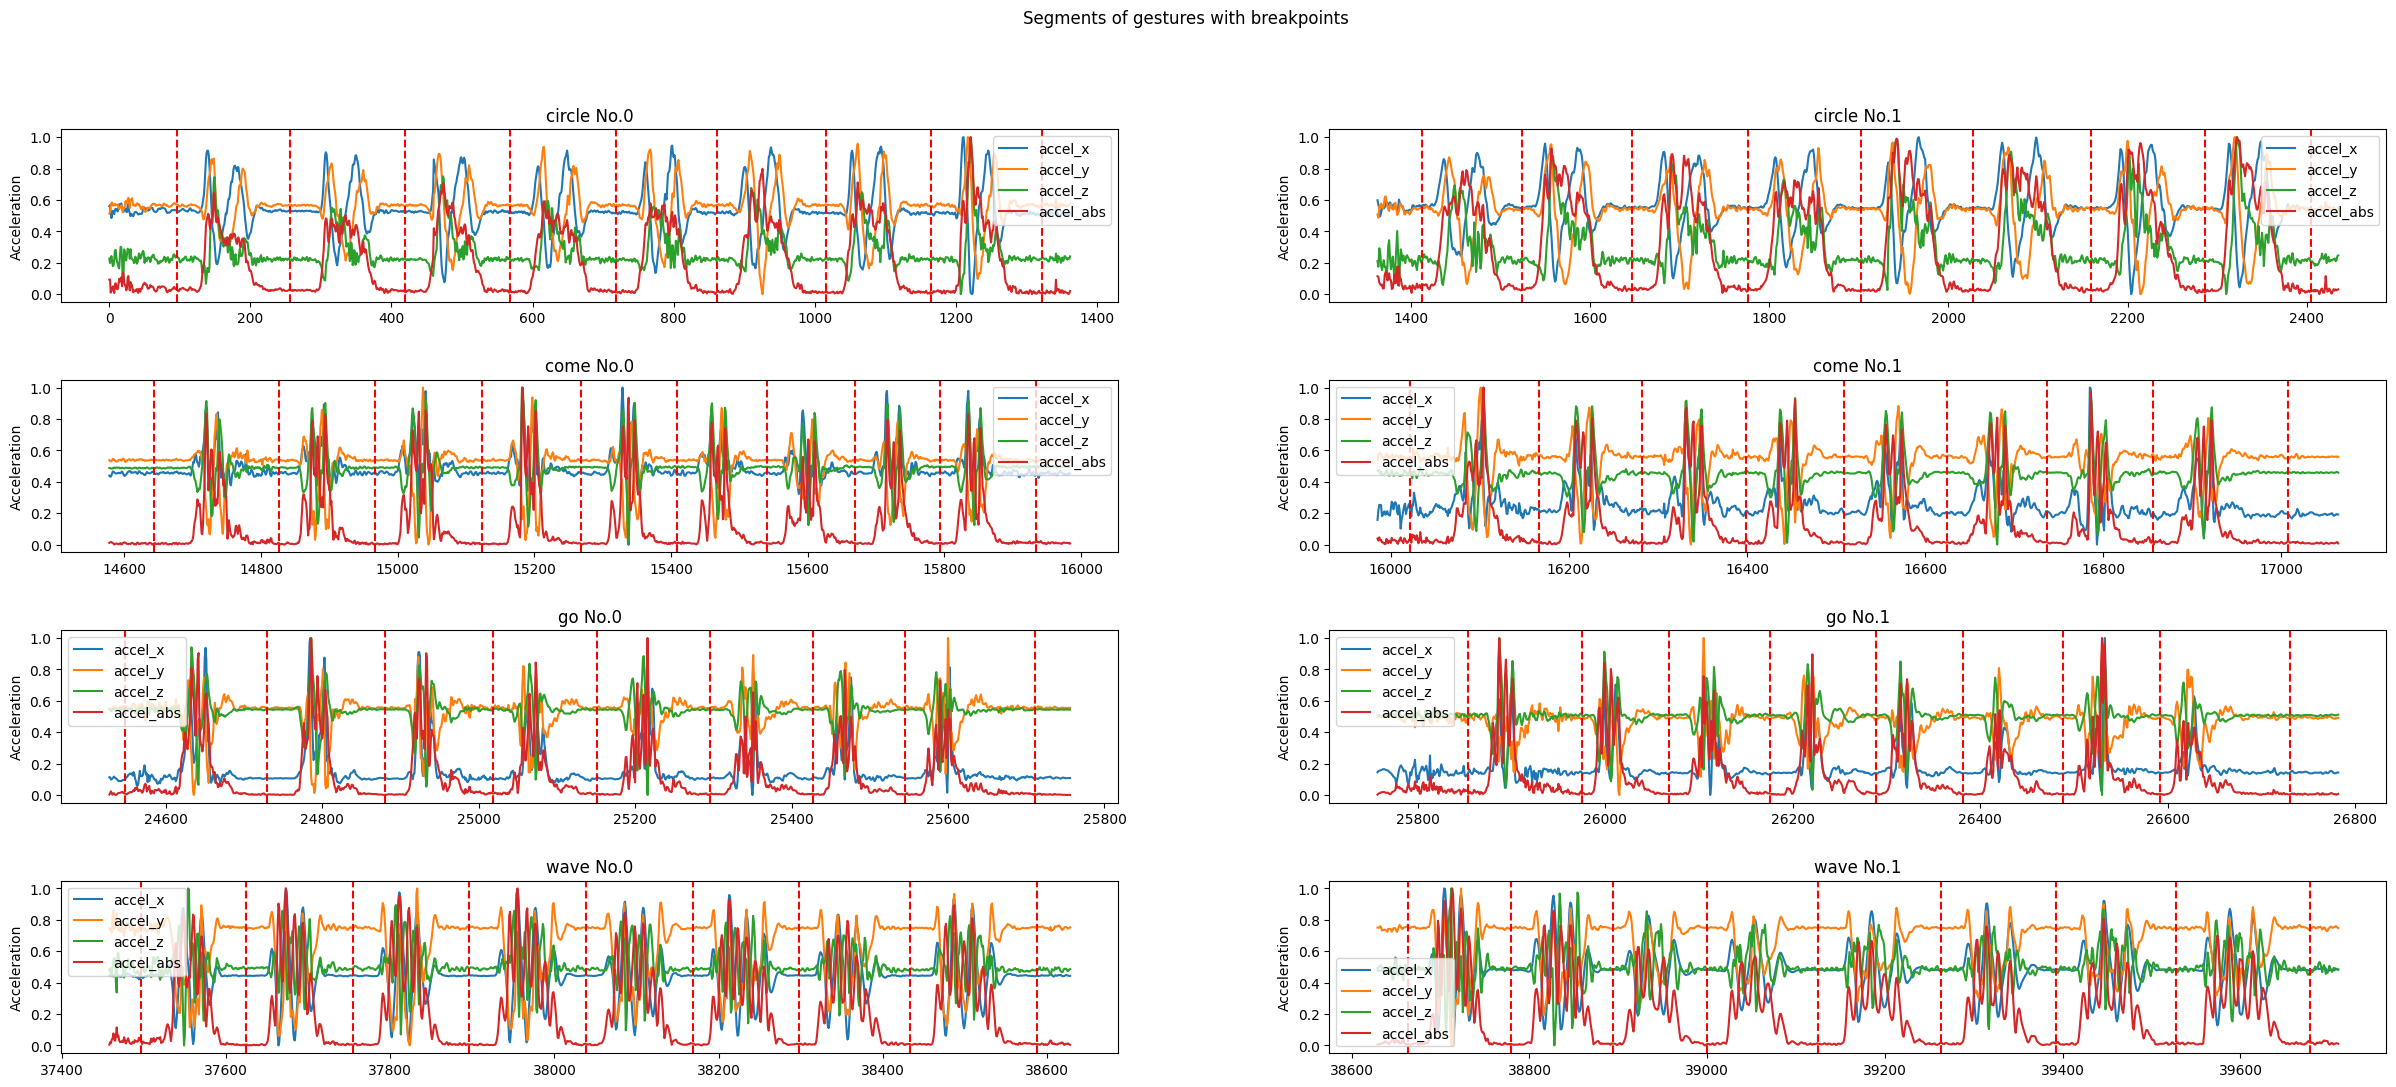

In [8]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for i, sub_group in feature.groupby('file_number'):

        below_threshold = indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
        breakpoints = merge_and_average_integers(below_threshold, 25)

        if i > 1:
            break

        plt.subplot(4, 2, plot)
        plot += 1

        for col in get_columns()[1:]:
            plt.plot(sub_group.index, sub_group[col], label=col)

        for index in breakpoints:
            plt.axvline(x=index, color='r', linestyle='--')

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{i}')
        plt.legend()
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We can safely remove the data where the absolute acceleration never gets above a certain threshold.

In [9]:
label_gestures(df, 'accel_abs',  0.3, rolling_window = 10, group_threshold = 5, deviation_threshold = deviation_threshold)

In [10]:
df

,time,accel_x,accel_y,accel_z,accel_abs,file_number,gesture,gesture_number
0,0.076475,0.542172,0.566608,0.217428,0.038565,0,circle,1.0
1,0.077203,0.536266,0.561221,0.229708,0.032645,0,circle,1.0
2,0.077931,0.533696,0.559384,0.232452,0.031049,0,circle,1.0
3,0.078659,0.529506,0.559515,0.239468,0.029429,0,circle,1.0
4,0.079388,0.528656,0.557858,0.233544,0.026873,0,circle,1.0
...,...,...,...,...,...,...,...,...
47117,0.970676,0.533817,0.923186,0.601583,0.022988,9,wave,307.0
47118,0.971275,0.534736,0.921991,0.603199,0.024799,9,wave,307.0
47119,0.971873,0.534174,0.921728,0.603683,0.024011,9,wave,307.0
47120,0.972472,0.533964,0.918852,0.602903,0.023259,9,wave,307.0


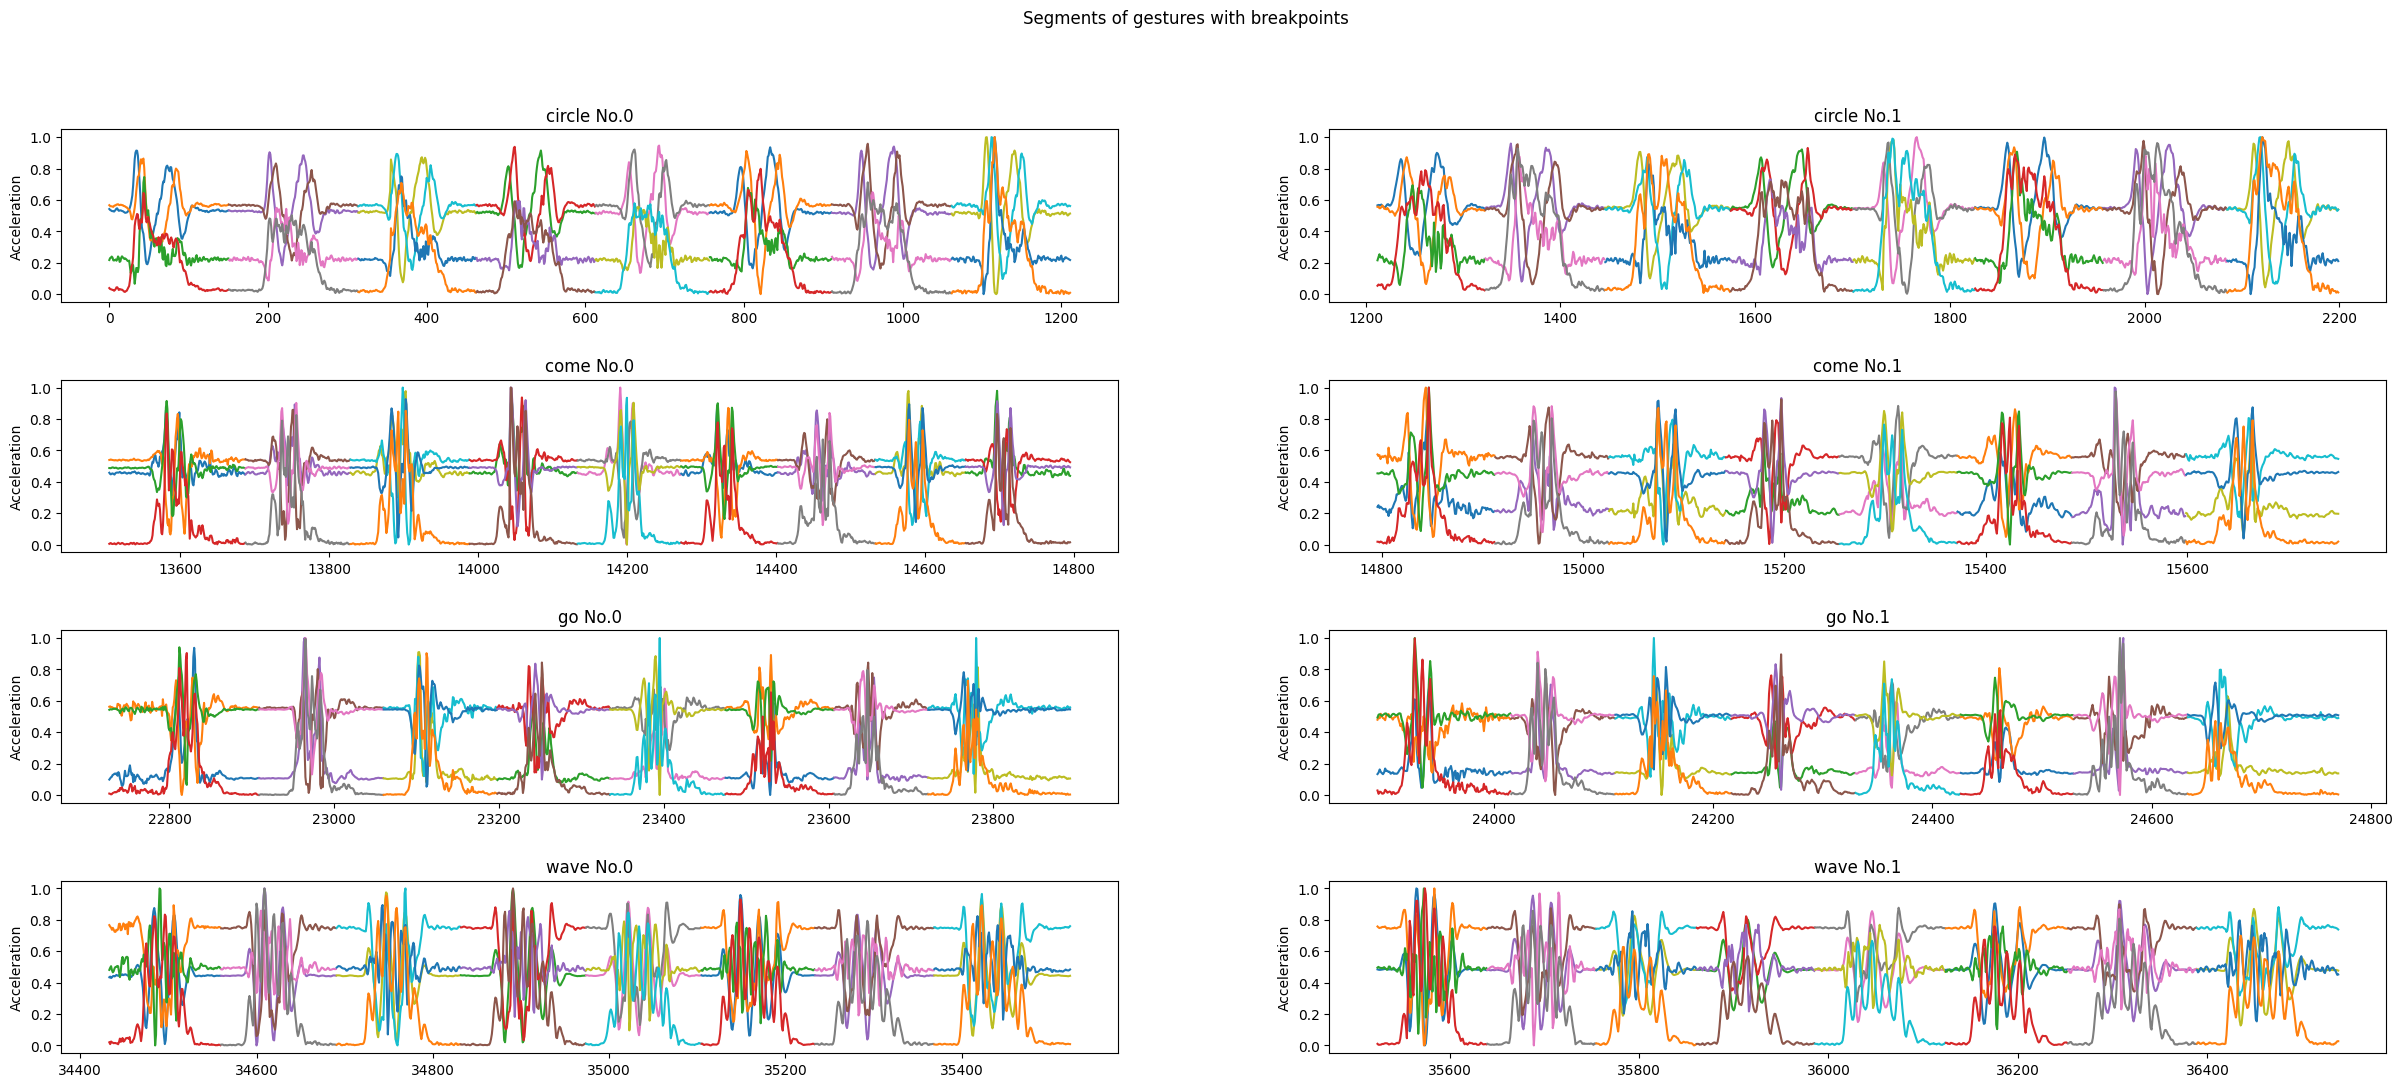

In [36]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for i, sub_group in feature.groupby('file_number'):

        if i > 1:
            break

        plt.subplot(4, 2, plot)
        plot += 1

        for gesture_number in sub_group['gesture_number'].unique():
            gesture_group = sub_group[sub_group['gesture_number'] == gesture_number]
            # plt.plot(gesture_group.index, gesture_group['accel_abs'], label=number_to_color(gesture))
        
            for col in get_columns()[1:]:
                plt.plot(gesture_group.index, gesture_group[col], label=number_to_color(gesture_number))

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{i}')
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

In [12]:
for label, group in df.groupby(['gesture', 'gesture_number']):
      if(group.shape[0] < 50):
            data = df[(df['gesture'] == label[0]) & (df['gesture_number'] == label[1])]
            print(label, data['file_number'].unique(), data['gesture_number'].unique())
            

('circle', 130.0) [4] [130.]
('circle', 238.0) [7] [238.]


Safest thing to do is to drop the first and last gesture from the data

In [40]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(labels):
    encoder = LabelEncoder()
    return encoder.fit_transform(labels)
    
# def extract_features(group):
#     (gesture, gesture_number), data = group
#     d = data.copy()
#     d.drop(columns=['time', 'file_number', 'gesture_number', 'gesture'], inplace=True)
#     for axis in get_columns()[1:]:
#         d[f'{axis}_mean'] = d[axis].mean()
#         d[f'{axis}_std'] = d[axis].std()
#     return d, gesture

def extract_features(group):
    (gesture, gesture_number), data = group
    d = []
    for axis in get_columns()[1:]:
        d.append(data[axis].mean())
        d.append(data[axis].std())
    return d, gesture

def get_features_and_labels():
    features = []
    original_labels = []

    extracted_features = [extract_features(group) for group in df.groupby(['gesture', 'gesture_number'])]
    for feature, label  in extracted_features:
        features.append(feature)
        original_labels.append(label)

    return features, original_labels

features, original_labels = get_features_and_labels()
labels = encode_labels(original_labels)

8


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)

In [47]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9838709677419355
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        14

    accuracy                           0.98        62
   macro avg       0.99      0.97      0.98        62
weighted avg       0.98      0.98      0.98        62

